<a href="https://colab.research.google.com/github/Dan-Jimenez/Clothing-classification/blob/main/clothing_classification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATA PREPARATION

In [ ]:
!pip install torchinfo

In [ ]:
import numpy as np
np.bool = bool
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

from torchvision import datasets
from torchvision import transforms

import random
from PIL import Image

import os
from imgaug import augmenters as iaa
from tqdm.auto import tqdm

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cuda


In [ ]:
from torch.utils.data import random_split
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))

train_size = int(0.8 * len(train_set))
val_size = len(train_set) - train_size

train_set, validation_set = random_split(train_set, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(validation_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

In [ ]:
len(train_set), len(validation_set), len(test_set)

(48000, 12000, 10000)

# DATA AUGMENTATION

In [ ]:
class ImgAugTransform:
    def __init__(self):
        self.aug = iaa.Sequential([
            iaa.Sometimes(0.3, iaa.AdditiveGaussianNoise(0, 0.1 * 255)),  # Reducción de la intensidad y probabilidad del ruido
            iaa.SomeOf(1, [  # Reducido a 1 transformación por vez para mayor eficiencia
                iaa.Affine(rotate=(-20, 20)),  # Rango más pequeño para la rotación
                iaa.Emboss(alpha=0.5, strength=0.5),  # Fuerza del relieve reducida
                iaa.Fliplr(0.5),  # Volteo horizontal con una probabilidad del 50%
                iaa.Dropout((0.01, 0.05), per_channel=False)  # Rango reducido de dropout y deshabilitado por canal
            ])
        ])

    def __call__(self, img):
        img = np.array(img)  # Convertir a un arreglo de NumPy
        img = self.aug.augment_image(img)  # Aplicar las transformaciones de aumento
        img = img.astype(np.float32)  # Asegurar que el formato sea de punto flotante
        return img

In [ ]:
train_transform = transforms.Compose([
    ImgAugTransform(),
    transforms.Lambda(lambda x: x / 255.0),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_set_aug = datasets.FashionMNIST("./data", download=True, train=True, transform=train_transform)
test_set_aug = datasets.FashionMNIST("./data", download=True, train=False, transform=test_transform)

In [ ]:
train_size = int(0.8 * len(train_set_aug))
val_size = len(train_set_aug) - train_size
train_set_aug, validation_set_aug = random_split(train_set_aug, [train_size, val_size])

train_loader_aug = DataLoader(train_set_aug, batch_size=64, shuffle=True)
val_loader_aug = DataLoader(validation_set_aug, batch_size=64, shuffle=False)
test_loader_aug = DataLoader(test_set_aug, batch_size=64, shuffle=False)

# PRIMER MODELO

In [ ]:
import torch.nn.functional as F

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2),  # Salida: 32x28x28
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),  # Salida: 32x14x14
        nn.Dropout(0.25)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),  # Salida: 64x14x14
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),  # Salida: 64x7x7
        nn.Dropout(0.25)
    )

    # Capas completamente conectadas
    self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Tamaño aplanado cambia a 64 * 7 * 7
    self.dropout = nn.Dropout(0.25)
    self.fc2 = nn.Linear(128, 10)  # Capa de salida para 10 clases

  def forward(self, x):
    # Aplicar las capas agrupadas
    x = self.layer1(x)  # Convolución + ReLU + Pooling
    x = self.layer2(x)  # Convolución + ReLU + Pooling
    # Aplanar antes de las capas completamente conectadas
    x = x.view(x.size(0), -1)  # Calcular dinámicamente el tamaño para flexibilidad
    # Aplicar capas completamente conectadas
    x = torch.relu(self.fc1(x))  # Completamente conectada + ReLU
    x = self.dropout(x)  # Aplicar dropout
    x = self.fc2(x)  # Capa de salida
    return F.log_softmax(x, dim=1)  # Logaritmo de probabilidades para estabilidad

model1 = CNN().to(device)

In [ ]:
# Loss function
criterion = nn.NLLLoss()

# Optimizer
optimizer = optim.Adam(model1.parameters(), lr=0.001)

In [ ]:
def train_model(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy

In [ ]:
def evaluate_model(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(val_loader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy

In [ ]:
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    loss_train = []
    acc_train = []
    loss_val = []
    acc_val = []

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        # Training
        train_loss, train_acc = train_model(model, train_loader, criterion, optimizer)
        loss_train.append(train_loss)
        acc_train.append(train_acc)

        # Evaluation
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)
        loss_val.append(val_loss)
        acc_val.append(val_acc)

        # Print metrics
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

    return loss_train, acc_train, loss_val, acc_val

In [ ]:
loss_train, acc_train, loss_val, acc_val = train_and_evaluate(
    model1, train_loader, val_loader, criterion, optimizer, epochs=10
)

Epoch 1/10
Train Loss: 0.4942, Train Accuracy: 82.01%
Val Loss: 0.3272, Val Accuracy: 87.46%
Epoch 2/10
Train Loss: 0.3486, Train Accuracy: 87.36%
Val Loss: 0.3080, Val Accuracy: 88.68%
Epoch 3/10
Train Loss: 0.3135, Train Accuracy: 88.44%
Val Loss: 0.2711, Val Accuracy: 89.73%
Epoch 4/10
Train Loss: 0.2868, Train Accuracy: 89.46%
Val Loss: 0.2601, Val Accuracy: 90.33%
Epoch 5/10
Train Loss: 0.2689, Train Accuracy: 90.01%
Val Loss: 0.2802, Val Accuracy: 89.46%
Epoch 6/10
Train Loss: 0.2587, Train Accuracy: 90.23%
Val Loss: 0.2745, Val Accuracy: 89.81%
Epoch 7/10
Train Loss: 0.2436, Train Accuracy: 90.94%
Val Loss: 0.2399, Val Accuracy: 91.38%
Epoch 8/10
Train Loss: 0.2321, Train Accuracy: 91.28%
Val Loss: 0.2352, Val Accuracy: 91.11%
Epoch 9/10
Train Loss: 0.2214, Train Accuracy: 91.66%
Val Loss: 0.2435, Val Accuracy: 90.94%
Epoch 10/10
Train Loss: 0.2165, Train Accuracy: 91.95%
Val Loss: 0.2319, Val Accuracy: 91.42%


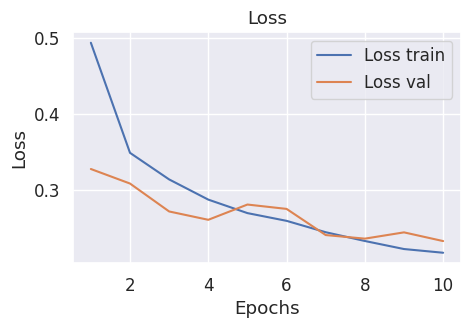

In [ ]:
# Plot Loss
plt.figure(figsize=(5, 3))
plt.plot(np.arange(1, len(loss_train) + 1), loss_train, label='Loss train')
plt.plot(np.arange(1, len(loss_val) + 1), loss_val, label='Loss val')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

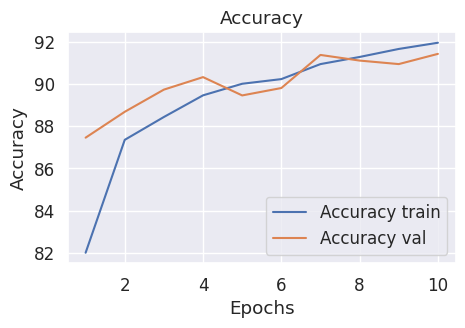

In [ ]:
# Plot Accuracy
plt.figure(figsize=(5, 3))
plt.plot(np.arange(1, len(acc_train) + 1), acc_train, label='Accuracy train')
plt.plot(np.arange(1, len(acc_val) + 1), acc_val, label='Accuracy val')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

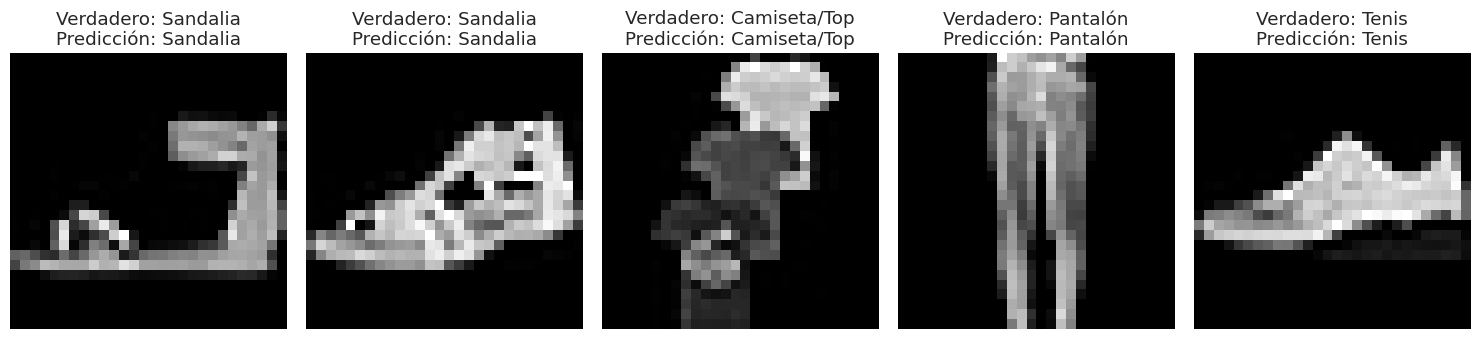

In [ ]:
# Mapeo para las etiquetas de salida
output_label = lambda label: [
    "Camiseta/Top", "Pantalón", "Suéter", "Vestido", "Abrigo",
    "Sandalia", "Camisa", "Tenis", "Bolsa", "Bota"
][label.item() if isinstance(label, torch.Tensor) else label]

# Visualizar algunas predicciones en el conjunto de validación
def visualize_predictions(model, val_loader, num_images=5):
    model.eval()
    data_iter = iter(val_loader)
    images, labels = next(data_iter)
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)
    images, labels, predictions = images.cpu(), labels.cpu(), predictions.cpu()
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        axes[i].imshow(images[i][0], cmap="gray")  # Mostrar la imagen en escala de grises
        axes[i].set_title(f"Verdadero: {output_label(labels[i])}\nPredicción: {output_label(predictions[i])}")
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

# Llamar a la función para visualizar las predicciones
visualize_predictions(model1, val_loader)

In [ ]:
from sklearn.metrics import classification_report

def evaluate_model_with_report(model, val_loader, class_names):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():  # Deshabilitar el cálculo de gradientes durante la evaluación
        for images, labels in val_loader:
            # Mover los datos al mismo dispositivo que el modelo
            images, labels = images.to(device), labels.to(device)

            # Paso hacia adelante y predicciones
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)

            # Recopilar todas las etiquetas verdaderas y predicciones
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    # Generar informe de clasificación
    report = classification_report(all_labels, all_predictions, target_names=class_names)
    print("Informe de Clasificación:")
    print(report)

# Nombres de las clases
class_names = [
    "Camiseta/Top", "Pantalón", "Suéter", "Vestido", "Abrigo",
    "Sandalia", "Camisa", "Tenis", "Bolsa", "Bota"
]

# Evaluar el modelo y generar el informe de clasificación
evaluate_model_with_report(model1, val_loader, class_names)


Informe de Clasificación:
              precision    recall  f1-score   support

Camiseta/Top       0.91      0.83      0.87      1232
    Pantalón       0.99      0.98      0.99      1146
      Suéter       0.90      0.82      0.86      1161
     Vestido       0.93      0.92      0.92      1198
      Abrigo       0.77      0.93      0.84      1176
    Sandalia       0.98      0.98      0.98      1165
      Camisa       0.77      0.75      0.76      1260
       Tenis       0.95      0.99      0.97      1190
       Bolsa       0.98      0.99      0.99      1272
        Bota       0.99      0.95      0.97      1200

    accuracy                           0.91     12000
   macro avg       0.92      0.92      0.92     12000
weighted avg       0.92      0.91      0.91     12000



# SEGUNDO MODELO

In [ ]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        # Capa 1: Primera capa convolucional
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2),  # Salida: 32x28x28
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Salida: 32x14x14
            nn.Dropout(0.2)  # Dropout reducido
        )
        # Capa 2: Segunda capa convolucional
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),  # Salida: 64x14x14
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Salida: 64x7x7
            nn.Dropout(0.2)  # Dropout reducido
        )
        # Capa 3: Tercera capa convolucional (Nueva)
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),  # Salida: 128x7x7
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Salida: 128x3x3
            nn.Dropout(0.25)
        )
        # Capas completamente conectadas
        self.fc1 = nn.Linear(128 * 3 * 3, 256)  # Tamaño incrementado para más parámetros entrenables
        self.fc2 = nn.Linear(256, 128)  # Se agregó una capa completamente conectada adicional
        self.fc3 = nn.Linear(128, 10)  # Capa de salida para 10 clases
        # Dropout
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.layer1(x)  # Capa 1
        x = self.layer2(x)  # Capa 2
        x = self.layer3(x)  # Capa 3 (Nueva)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))  # Completamente conectada + ReLU
        x = self.dropout(x)  # Dropout
        x = torch.relu(self.fc2(x))  # Completamente conectada + ReLU
        x = self.fc3(x)  # Capa de salida
        return x

model2 = CNN2().to(device)


In [ ]:
# Loss function
criterion2 = nn.CrossEntropyLoss()

# Optimizer
optimizer2 = optim.AdamW(model2.parameters(), lr=0.001, weight_decay=0.01)

In [ ]:
def train_model(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backpropagation and optimizer step
        loss.backward()
        optimizer.step()

        # Accumulate metrics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy

In [ ]:
def evaluate_model(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Accumulate metrics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(val_loader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy

In [ ]:
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, epochs=15):
    loss_train = []
    acc_train = []
    loss_val = []
    acc_val = []

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        # Train for one epoch
        train_loss, train_acc = train_model(model, train_loader, criterion, optimizer)
        loss_train.append(train_loss)
        acc_train.append(train_acc)

        # Validate for one epoch
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)
        loss_val.append(val_loss)
        acc_val.append(val_acc)

        # Print metrics for the epoch
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

    return loss_train, acc_train, loss_val, acc_val

# Execute training and evaluation
loss_train, acc_train, loss_val, acc_val = train_and_evaluate(
    model2, train_loader_aug, val_loader_aug, criterion2, optimizer2, epochs=15
)

Epoch 1/15
Train Loss: 0.6301, Train Accuracy: 76.58%
Validation Loss: 0.4537, Validation Accuracy: 83.11%
Epoch 2/15
Train Loss: 0.4493, Train Accuracy: 83.30%
Validation Loss: 0.3774, Validation Accuracy: 85.67%
Epoch 3/15
Train Loss: 0.4081, Train Accuracy: 84.91%
Validation Loss: 0.3466, Validation Accuracy: 86.83%
Epoch 4/15
Train Loss: 0.3830, Train Accuracy: 85.79%
Validation Loss: 0.3434, Validation Accuracy: 87.42%
Epoch 5/15
Train Loss: 0.3683, Train Accuracy: 86.18%
Validation Loss: 0.3317, Validation Accuracy: 87.53%
Epoch 6/15
Train Loss: 0.3569, Train Accuracy: 86.68%
Validation Loss: 0.3172, Validation Accuracy: 87.98%
Epoch 7/15
Train Loss: 0.3504, Train Accuracy: 86.94%
Validation Loss: 0.3143, Validation Accuracy: 87.93%
Epoch 8/15
Train Loss: 0.3356, Train Accuracy: 87.56%
Validation Loss: 0.2903, Validation Accuracy: 89.29%
Epoch 9/15
Train Loss: 0.3279, Train Accuracy: 87.80%
Validation Loss: 0.3008, Validation Accuracy: 88.67%
Epoch 10/15
Train Loss: 0.3230, Train

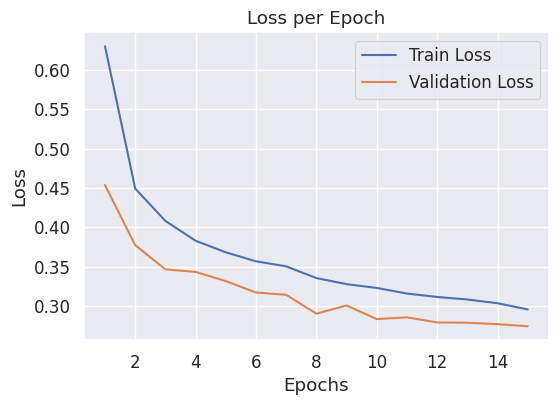

In [ ]:
# Plot Loss
plt.figure(figsize=(6, 4))
plt.plot(np.arange(1, len(loss_train) + 1), loss_train, label='Train Loss')
plt.plot(np.arange(1, len(loss_val) + 1), loss_val, label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

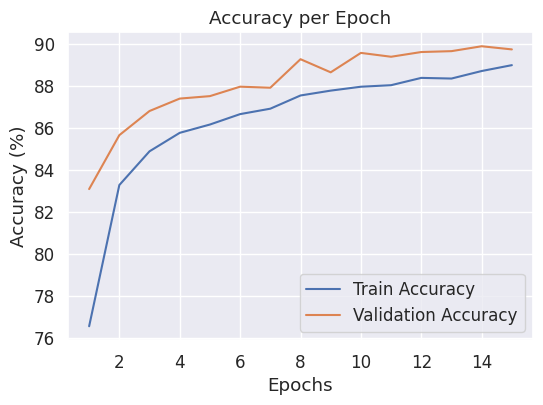

In [ ]:

# Plot Accuracy
plt.figure(figsize=(6, 4))
plt.plot(np.arange(1, len(acc_train) + 1), acc_train, label='Train Accuracy')
plt.plot(np.arange(1, len(acc_val) + 1), acc_val, label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

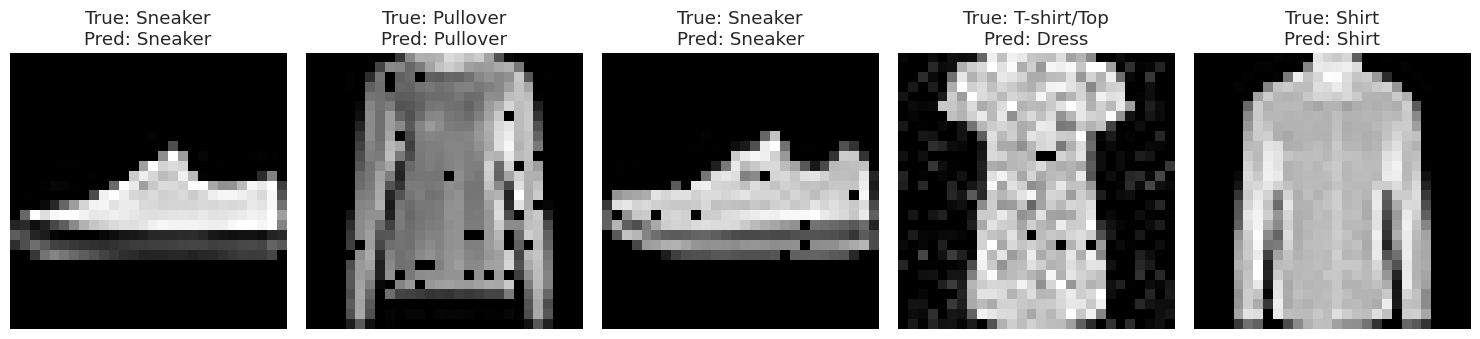

In [ ]:
# Mapping for output labels
output_label = lambda label: [
    "T-shirt/Top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"
][label.item() if isinstance(label, torch.Tensor) else label]

def visualize_predictions(model, val_loader_aug, num_images=5):
    model.eval()
    data_iter = iter(val_loader_aug)
    images, labels = next(data_iter)

    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)

    images, labels, predictions = images.cpu(), labels.cpu(), predictions.cpu()

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        axes[i].imshow(images[i][0], cmap="gray")
        axes[i].set_title(f"True: {output_label(labels[i])}\nPred: {output_label(predictions[i])}")
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

visualize_predictions(model2, val_loader_aug, num_images=5)

In [ ]:
from sklearn.metrics import classification_report

def evaluate_model_with_report(model, val_loader_aug, class_names):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in val_loader_aug:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    report = classification_report(all_labels, all_predictions, target_names=class_names)
    print("Classification Report:")
    print(report)

class_names = [
    "T-shirt/Top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"
]

evaluate_model_with_report(model2, val_loader_aug, class_names)

Classification Report:
              precision    recall  f1-score   support

 T-shirt/Top       0.88      0.79      0.84      1215
     Trouser       1.00      0.98      0.99      1152
    Pullover       0.85      0.84      0.84      1173
       Dress       0.90      0.92      0.91      1209
        Coat       0.80      0.88      0.84      1192
      Sandal       0.99      0.94      0.97      1215
       Shirt       0.72      0.74      0.73      1222
     Sneaker       0.92      0.98      0.95      1184
         Bag       0.99      0.97      0.98      1236
  Ankle Boot       0.97      0.96      0.96      1202

    accuracy                           0.90     12000
   macro avg       0.90      0.90      0.90     12000
weighted avg       0.90      0.90      0.90     12000



# UTILIZANDO TRANSFER LEARNING

In [ ]:
# Obtener los pesos de u modelo preentrenado
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT= mejores pesos disponibles de un modelo preentrenado
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [ ]:
# Observar las transformaciones que se le realizaron al modelo preentrenado
efficientnet_transforms = weights.transforms()
efficientnet_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
transformations = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

train_set_aug = datasets.FashionMNIST("./data", download=True, train=True, transform=transformations)
test_set_aug = datasets.FashionMNIST("./data", download=True, train=False, transform=transformations)

train_size = int(0.8 * len(train_set_aug))
val_size = len(train_set_aug) - train_size
train_set_aug, validation_set_aug = random_split(train_set_aug, [train_size, val_size])

train_loader_aug = DataLoader(train_set_aug, batch_size=64, shuffle=True)
val_loader_aug = DataLoader(validation_set_aug, batch_size=64, shuffle=False)
test_loader_aug = DataLoader(test_set_aug, batch_size=64, shuffle=False)

In [ ]:
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [ ]:
# Despliega un resumen del modelo
summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [ ]:
# Definimos el optimizador
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Definimos la función de costo
criterion = nn.CrossEntropyLoss()

In [ ]:
def accuracy(y_true, y_pred):
    y_pred = y_pred.round()
    correct = torch.eq(y_true,y_pred).sum().item()
    acc = (correct/len(y_pred))
    return acc

In [ ]:
def train(dataloader: DataLoader, model: nn.Module, criterion, optimizer):
    model.train()
    epoch_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    for batch in dataloader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device).to(torch.int64)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, predictions = torch.max(outputs, dim=1)
        correct_predictions += (predictions == labels).sum().item()
        total_samples += labels.size(0)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)
    avg_accuracy = correct_predictions / total_samples

    print(f"Train loss: {avg_loss:.4f} | Train accuracy: {avg_accuracy*100:.2f}%")
    return avg_loss, avg_accuracy


In [ ]:
def evaluate_model(dataloader: DataLoader, model: nn.Module, criterion):
    model.eval()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.inference_mode():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device).to(torch.int64)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predictions = torch.max(outputs, dim=1)
            correct_predictions += (predictions == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    avg_accuracy = correct_predictions / total_samples

    print(f"Evaluation loss: {avg_loss:.4f} | Evaluation accuracy: {avg_accuracy*100:.2f}%")
    return avg_loss, avg_accuracy


In [ ]:
EPOCHS = 2
loss_train = []
acc_train = []
loss_test = []
acc_test = []
for epoch in tqdm(range(EPOCHS), desc="Epochs"):
    print(f"Epoch: {epoch+1}/{EPOCHS}\n--------")
    train_loss, train_acc = train(train_loader_aug, model, criterion, optimizer)
    test_loss, test_acc = evaluate_model(val_loader_aug, model, criterion)
    loss_train.append(train_loss)
    loss_test.append(test_loss)
    acc_train.append(train_acc)
    acc_test.append(test_acc)

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 1/2
--------
Train loss: 0.3430 | Train accuracy: 88.68%
Evaluation loss: 0.1991 | Evaluation accuracy: 93.02%
Epoch: 2/2
--------
Train loss: 0.1985 | Train accuracy: 92.88%
Evaluation loss: 0.1911 | Evaluation accuracy: 93.33%


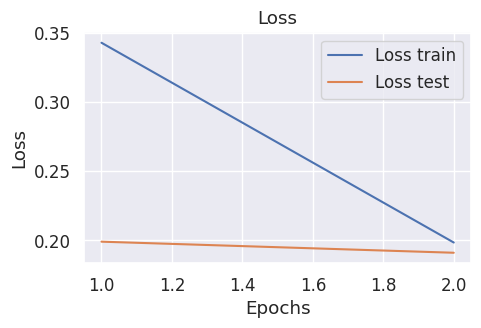

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,EPOCHS+1), loss_train)
plt.plot(np.arange(1,EPOCHS+1), loss_test)
plt.title('Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Loss train', 'Loss test'])
plt.show()

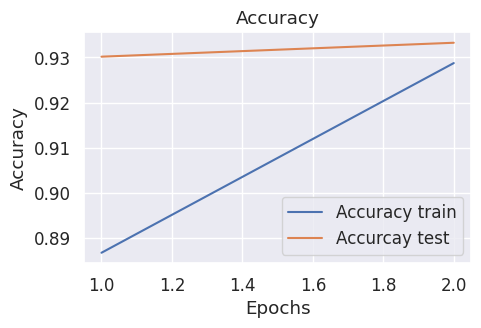

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,EPOCHS+1), acc_train)
plt.plot(np.arange(1,EPOCHS+1), acc_test)
plt.title('Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Accuracy train', 'Accurcay test'])
plt.show()

# MODELO FINAL

In [ ]:
y_preds = []
y_true = []
model.eval()
with torch.inference_mode():
    for X, y in tqdm(test_loader_aug, desc="Making predictions ..."):
        X = X.to(device)
        y_pred_logs = model(X)
        y_pred = torch.argmax(y_pred_logs, dim=1)
        y_preds.append(y_pred.cpu())
        y_true.append(y.cpu())

y_preds = torch.cat(y_preds)
y_true = torch.cat(y_true)

Making predictions ...:   0%|          | 0/157 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_true, y_preds)
cf_matrix

array([[911,   0,  31,   9,   1,   0,  44,   0,   4,   0],
       [  0, 982,   0,  15,   0,   0,   2,   0,   1,   0],
       [ 11,   0, 949,   6,  23,   0,  11,   0,   0,   0],
       [ 21,   0,  15, 934,  14,   0,  16,   0,   0,   0],
       [  1,   1,  52,  26, 903,   0,  17,   0,   0,   0],
       [  0,   0,   0,   1,   0, 966,   0,  32,   0,   1],
       [133,   1,  77,  20,  63,   0, 704,   0,   2,   0],
       [  0,   0,   0,   0,   0,   0,   0, 988,   0,  12],
       [  2,   0,   1,   3,   1,   1,   1,   2, 989,   0],
       [  0,   0,   0,   1,   0,   3,   0,  43,   1, 952]])

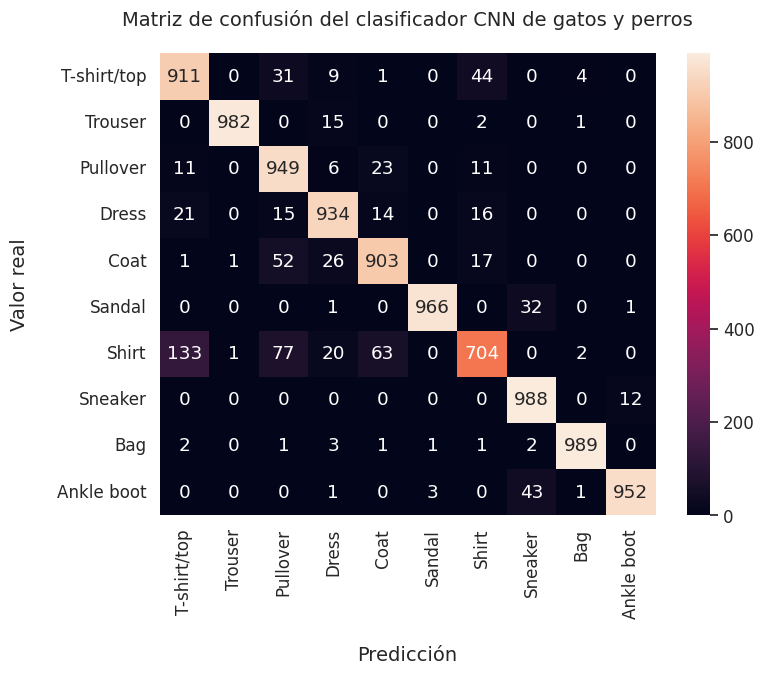

In [ ]:
import seaborn as sns
plt.figure(figsize=(8,6))

sns.set(font_scale = 1.1)

ax = sns.heatmap(cf_matrix, annot=True, fmt='d', )

# set x-axis label and ticks.
ax.set_xlabel("Predicción", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(test_set.classes, rotation=90)

# set y-axis label and ticks
ax.set_ylabel("Valor real", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(test_set.classes, rotation=0)

# set plot title
ax.set_title("Matriz de confusión del clasificador CNN de gatos y perros", fontsize=14, pad=20)
plt.show()

In [ ]:
print(classification_report(y_true, y_preds))

              precision    recall  f1-score   support

           0       0.84      0.91      0.88      1000
           1       1.00      0.98      0.99      1000
           2       0.84      0.95      0.89      1000
           3       0.92      0.93      0.93      1000
           4       0.90      0.90      0.90      1000
           5       1.00      0.97      0.98      1000
           6       0.89      0.70      0.78      1000
           7       0.93      0.99      0.96      1000
           8       0.99      0.99      0.99      1000
           9       0.99      0.95      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000

